# PREDIÇÃO PARA QUANTIDADE DE NOTAS FISCAIS COVID

#### IMPORTAÇÕES

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import math
from IPython.display import display, Markdown, Image
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from scipy.stats import pearsonr
import random

from pickle import dump
from pickle import load

# IMPORT REDES NEURAIS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit

#### FUNÇÕES

### Função para cálculo do Fator de 2

In [2]:
def get_fac2(y_true, y_pred):
    min_ = 0.5
    max_ = 2
    
    eps = np.finfo(np.float).eps
    
    division = y_pred / (y_true+eps)
    
    greater_min = np.greater_equal(division, min_)
    less_max = np.less_equal(division, max_)

    res = np.equal(greater_min, less_max)
    res = res.astype(float)

    fac_2 = res.mean()

    return fac_2

In [3]:
def plot_samples(y_true, y_pred, title='', xlabel='', ylabel='', filename="LSTM"):
    
    plt.figure(figsize=(14, 18))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        days = list(range(col+1, (col+1)+len(y_true)))
        
        plt.subplot(8, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.plot(days, y_true.iloc[:, col], label='Real')
        plt.plot(days, y_pred.iloc[:, col], label='Previsão')
        plt.legend()
        plt.xlabel(xlabel, fontsize=10)
        plt.ylabel(ylabel, fontsize=10)
        plt.xlim(left=days[0], right=days[-1])
        plt.xticks(np.linspace(days[0], days[-1], num=5, dtype=int))
    plt.tight_layout()    
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
#     plt.savefig(filename +"_plot_samples.png", dpi=600)
    plt.show()
    
def plot_scatter(y_true, y_pred, title='', filename="LSTM"):
    
    plt.figure(figsize=(14, 18))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        max_val = max(y_true.iloc[:, col].max(), y_pred.iloc[:, col].max())
        min_val = min(y_true.iloc[:, col].min(), y_pred.iloc[:, col].min())
                
        max_lim = max_val + max_val*0.05
        max_lim = math.ceil(max_lim)
        
        ndigits = len(str(max_lim))
        max_lim = int(math.ceil(max_lim / (10.0**(ndigits-2)) )) * (10.0**(ndigits-2))
        
        min_lim = min_val - max_val*0.05
        min_lim = max(0, min_lim)
        
        plt.subplot(8, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.scatter(y_true.iloc[:, col], y_pred.iloc[:, col])
        plt.xlabel('Real', fontsize=10)
        plt.ylabel('Previsão', fontsize=10)
        
        plt.xlim(left=min_lim, right=max_lim)
        plt.ylim(top=max_lim, bottom=min_lim)
        
        plt.xticks(np.linspace(min_lim, max_lim, num=5, dtype=int))
        plt.yticks(np.linspace(min_lim, max_lim, num=5, dtype=int))

        plt.plot([min_lim, max_lim], [min_lim, max_lim])
   
    plt.tight_layout()       
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
#     plt.savefig(filename + "_plot_scatter.png", dpi=600)
    plt.show()
    
def get_metrics(y_true, y_pred, filename="LSTM"):
    
    metrics = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'Pearson r', 'Fac2'])
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        y_true_col = y_true.iloc[:, col]
        y_pred_col = y_pred.iloc[:, col]

        if y_true_col.name == y_pred_col.name:
            col_name = y_true_col.name
        else:
            print('Column name error.')
            return None

        mse = mean_squared_error(y_true_col, y_pred_col)
        rmse = mean_squared_error(y_true_col, y_pred_col, squared=False)
        mae = mean_absolute_error(y_true_col, y_pred_col)
        pearson_r = pearsonr(y_true_col, y_pred_col)[0]
        fac2 = get_fac2(y_true_col.values, y_pred_col.values)
        metrics.loc[col_name, :] = [mse, rmse, mae, pearson_r, fac2]

    metrics.loc['Average', :] = metrics.mean()
#     metrics.to_csv(filename + "_Metricas.csv",index=False)
    return metrics

def plot_metrics(metrics, title='', xlabel='', ylabel='', filename="LSTM"):
    
    plt.figure(figsize=(14, 12))
    plt.suptitle(title, fontsize=14, y=0.935)
    
    metrics_names = metrics.columns
    time_steps = list(range(1, metrics.shape[0]))
    
    for col, metric_name in enumerate(metrics_names):
        
        plt.subplot(3, 2, col+1)
        plt.title('{} para cada horizonte de previsão'.format(metric_name))
        plt.plot(time_steps, metrics.iloc[0:-1, col], marker='o', label=metric_name)
        plt.legend()
        plt.xlabel('Dias a frente', fontsize=10)
        plt.ylabel(metric_name, fontsize=10)
        plt.xlim(left=time_steps[0], right=time_steps[-1])
        plt.xticks(np.linspace(time_steps[0], time_steps[-1], num=5, dtype=int))
        
#     plt.savefig(filename + "_plot_metrics.png", dpi=600)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.show()

In [4]:
def generate_single_region_dataset(key, region_data, look_back, look_forward, x_columns, y_columns=None, gen_x=True, gen_y=True):
    
    # Check region dataframe
    if region_data is None:
        print('generate_single_region_dataset error: Region data is None!')
        return (None, None)
    
    # Check number of regions
    if len(region_data[key].unique()) > 1:
        print('generate_single_region_dataset error: More than one region in the dataframe!')
        return (None, None)
    else:
        region_name = region_data[key].unique()[0]
    
    # Drop 'Region' column
    region_data = region_data.drop(columns=key)
    
    # Check the number of samples available to
    # generate the look back and look forward windows
    if len(region_data) < (look_back + look_forward):
        print('generate_single_region_dataset error: Not enough samples '+
              'in {} to generate the windows!'.format(region_name))
        return (None, None)
    
    n_samples = len(region_data) - look_back - look_forward + 1

    var_names = x_columns
    
    # Generate inputs
    if gen_x:
        inputs = pd.DataFrame()
        
        for i in range(n_samples):
            input_window = region_data.T.iloc[:, i:i+look_back]
            wide_input_sample = pd.DataFrame()
            
            for var in var_names:
                var_input_sample = input_window.loc[var:var, :]
                var_input_sample.columns = ['{}_t{}'.format(var, a) for a in range(1-look_back, 1)]
                var_input_sample = var_input_sample.reset_index(drop=True)
                wide_input_sample = pd.concat([wide_input_sample, var_input_sample], axis='columns')
                
            inputs = pd.concat([inputs, wide_input_sample], axis='index')
            
        # Insert region name
        #inputs.insert(loc=0, column=key, value=region_name)
        # Reset index
        inputs = inputs.reset_index(drop=True)

    # Generate outputs
    if gen_y:
        
        if y_columns is None:
            print('generate_single_region_dataset error: Need to specify column labels!')
            return (None, None)
        
        var_names = y_columns
        outputs = pd.DataFrame()
        
        for i in range(n_samples):
            output_window = region_data.T.iloc[:, i+look_back : i+look_back+look_forward]
            wide_output_sample = pd.DataFrame()

            for var in var_names:
                var_output_sample = output_window.loc[var:var, :]
                var_output_sample.columns = ['{}_t+{}'.format(var, a) for a in range(1, look_forward+1)]
                var_output_sample = var_output_sample.reset_index(drop=True)
                wide_output_sample = pd.concat([wide_output_sample, var_output_sample], axis='columns')

            outputs = pd.concat([outputs, wide_output_sample], axis='index')
        
        # Insert region name
        #outputs.insert(loc=0, column=key, value=region_name)
        # Reset index
        outputs = outputs.reset_index(drop=True)
        
    if gen_x and gen_y:
        return (inputs, outputs)
    elif gen_x:
        return (inputs, None)
    elif gen_y:
        return (None, outputs)

In [5]:
def generate_regions_dataset(key, regions_data, look_back, look_forward, x_columns, y_columns=None, 
                             gen_x=True, gen_y=True):
    
    regions_names = regions_data[key].unique()
    
    all_regions_x = pd.DataFrame()
    all_regions_y = pd.DataFrame()
    
    for region_name in regions_names:
        
        region_data = regions_data[regions_data[key]==region_name]
        
        region_x, region_y = generate_single_region_dataset(key,
            region_data, look_back=look_back, look_forward=look_forward, x_columns=x_columns, y_columns=y_columns,
            gen_x=gen_x, gen_y=gen_y
        )
        
        if not (region_x is None):
            all_regions_x = pd.concat([all_regions_x, region_x])
            all_regions_x = all_regions_x.reset_index(drop=True)
            
        if not (region_y is None):
            all_regions_y = pd.concat([all_regions_y, region_y])
            all_regions_y = all_regions_y.reset_index(drop=True)
    
    if gen_x and gen_y:
        return (all_regions_x, all_regions_y)
    elif gen_x:
        return (all_regions_x, None)
    elif gen_y:
        return (None, all_regions_y)

In [6]:
lookback = 4
lookforward= 30

In [7]:
#["day_of_week", "populacao", "Confirmed", "Deaths", "Valor Autorizados", "Qtde Autorizados_2019_mean",'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
def create_dataset(model_confirmed, model_deaths, normalizador_confirmed, normalizador_deaths, normalizador_notas, data):
    new_data = data.drop(['day_of_week_t-{}'.format(i) for i in range(1,lookback)], axis=1)
    new_data = new_data.drop(['day_of_week_t0'], axis=1)
    
    new_data = new_data.drop(['populacao_t-{}'.format(i) for i in range(1,lookback)], axis=1)
    new_data = new_data.drop(['populacao_t0'], axis=1)
    
    #new_data = new_data.drop(['Valor Autorizados_t-{}'.format(i) for i in range(1,lookback)], axis=1)
    #new_data = new_data.drop(['Valor Autorizados_t0'], axis=1)
    
    new_data = new_data.drop(['Qtde Autorizados_2019_mean_t-{}'.format(i) for i in range(1,lookback)], axis=1)
    new_data = new_data.drop(['Qtde Autorizados_2019_mean_t0'], axis=1)
    
    new_data = new_data.drop(['Qtde Autorizados_t-{}'.format(i) for i in range(1,lookback)], axis=1)
    new_data = new_data.drop(['Qtde Autorizados_t0'], axis=1)
    
    #Predictions Confirmed
    new_data_x_conf_scaler = normalizador_confirmed.transform(new_data)
    
    new_data_reshaped = np.empty([new_data_x_conf_scaler.shape[0], 4, 10])

    k = 0
    for i in range(10):
        for j in range(4):
            new_data_reshaped[:, j, i] = new_data_x_conf_scaler[:, k]
            k = k + 1

    new_data_pred_conf = model_confirmed.predict(new_data_reshaped)
    
    #Predictions Deaths
    new_data_x_death_scaler = normalizador_deaths.transform(new_data)

    new_data_reshaped = np.empty([new_data_x_death_scaler.shape[0], 4, 10])

    k = 0
    for i in range(10):
        for j in range(4):
            new_data_reshaped[:, j, i] = new_data_x_death_scaler[:, k]
            k = k + 1

    new_data_pred_deaths = model_deaths.predict(new_data_reshaped)
    
    #Creating dataset
    
    new_data = normalizador_notas.transform(data)
    new_data = np.append(new_data, new_data_pred_conf, axis=1)
    new_data = np.append(new_data, new_data_pred_deaths, axis=1)
    
    return new_data

#### LEITURA DOS DADOS DO GRUPO

## TREINO, VALIDAÇÃO E TESTE

In [8]:
dados = pd.read_csv("../dataset/brazil_states_dataset_notas_2020-08-07_completo.csv",  sep="," , decimal=".", parse_dates=['Date'])

train_states = ['RO', 'RR', 'SE', 'RN', 'AC', 'RS', 'PI', 'PB']
val_states = ['ES', 'AL']
test_states = ['BA', 'RJ']

regions_train =dados[dados["Country/Region"].isin(list(train_states))]
regions_val = dados[dados["Country/Region"].isin(list(val_states))]
regions_test = dados[dados["Country/Region"].isin(list(test_states))]

regions_train

,Date,Country/Region,day_of_week,Qtde Autorizados,Valor Autorizados,populacao,Confirmed,Deaths,C1,C2,...,C5,C6,C7,C8,preinflex,peak,postinflex,estagio,Qtde Autorizados_2019_mean,Valor Autorizados_2019_mean
0,2020-03-19,AC,3,151555.0,11071687.93,881935,3,0,0,0,...,0,0,0,0,50.0,93.0,136.0,5.0,157935.934247,1.130211e+07
1,2020-03-20,AC,4,143065.0,10666185.42,881935,4,0,0,1,...,1,0,1,1,50.0,93.0,136.0,5.0,157935.934247,1.130211e+07
2,2020-03-21,AC,5,129421.0,10022350.32,881935,2,0,0,1,...,1,0,1,1,50.0,93.0,136.0,5.0,157935.934247,1.130211e+07
3,2020-03-22,AC,6,74233.0,4811909.35,881935,2,0,0,1,...,1,0,1,1,50.0,93.0,136.0,5.0,157935.934247,1.130211e+07
4,2020-03-23,AC,0,126547.0,9125267.83,881935,0,0,0,1,...,1,0,1,1,50.0,93.0,136.0,5.0,157935.934247,1.130211e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1752,2020-08-02,SE,6,192993.0,16499379.73,2298696,311,17,0,0,...,0,0,0,0,86.0,139.0,192.0,4.0,454189.657534,3.609913e+07
1753,2020-08-03,SE,0,421070.0,39982259.63,2298696,444,24,0,0,...,0,0,0,0,86.0,139.0,192.0,4.0,454189.657534,3.609913e+07
1754,2020-08-04,SE,1,415255.0,40242063.01,2298696,590,20,0,0,...,0,0,0,0,86.0,139.0,192.0,4.0,454189.657534,3.609913e+07
1755,2020-08-05,SE,2,422734.0,40922148.45,2298696,917,16,0,0,...,0,0,0,0,86.0,139.0,192.0,4.0,454189.657534,3.609913e+07


In [9]:
x_columns = ["day_of_week", "populacao", "Deaths", "Confirmed", "Qtde Autorizados", "Qtde Autorizados_2019_mean",'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
y_columns = ["Qtde Autorizados"]

train_x, train_y = generate_regions_dataset("Country/Region", regions_train, lookback, lookforward, x_columns, y_columns=y_columns)
val_x, val_y = generate_regions_dataset("Country/Region", regions_val, lookback, lookforward, x_columns, y_columns=y_columns)
test_x, test_y = generate_regions_dataset("Country/Region", regions_test, lookback, lookforward, x_columns, y_columns=y_columns)

In [10]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_scaler.fit(train_x)

y_train_scaled = y_scaler.fit_transform(train_y)
y_test_scaled = y_scaler.transform(test_y)
y_val_scaled = y_scaler.transform(val_y)

In [11]:
confirmed_model_path = '../../models_epidemic_cnn_lstm_real/confirmed/'
deaths_model_path = '../../models_epidemic_cnn_lstm_real/deaths/'

In [12]:
model_confirmed = tf.keras.models.load_model(confirmed_model_path+'FULL_DATASET_CONFIRMED_Modelo_CNN_LSTM.h5')
model_deaths = tf.keras.models.load_model(deaths_model_path+'FULL_DATASET_DEATHS_Modelo_CNN_LSTM.h5')

In [13]:
normalizador_confirmed = load(open(confirmed_model_path+"Normalizador_Preditores_CONFIRMADOS.pkl", "rb"))
normalizador_deaths = load(open(deaths_model_path+"Normalizador_Preditores_MORTES.pkl", "rb"))

In [14]:
x_train_scaled = create_dataset(model_confirmed, model_deaths, normalizador_confirmed,normalizador_deaths,x_scaler,train_x)
x_val_scaled = create_dataset(model_confirmed, model_deaths, normalizador_confirmed,normalizador_deaths,x_scaler,val_x)
x_test_scaled = create_dataset(model_confirmed, model_deaths, normalizador_confirmed,normalizador_deaths,x_scaler,test_x)

In [15]:
x_val_scaled.shape

(240, 116)

In [16]:
x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0],1 , x_train_scaled.shape[1]))
x_test_scaled= np.reshape(x_test_scaled, (x_test_scaled.shape[0],1, x_test_scaled.shape[1]))
x_val_scaled= np.reshape(x_val_scaled, (x_val_scaled.shape[0],1 , x_val_scaled.shape[1]))

In [17]:
#Arquitetura da RNA
activation = 'relu'
opt = optimizers.Adamax()

tf.random.set_seed(0)

modelo = Sequential()
modelo.add(LSTM(units = 120, return_sequences = True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001),input_shape = (x_train_scaled.shape[1],x_train_scaled.shape[2])))
modelo.add(LSTM(units = 120, activation = 'relu'))
modelo.add(Dense(units = lookforward, activation = 'linear'))

modelo.compile(optimizer=opt, loss='mse')

history = modelo.fit(x_train_scaled, y_train_scaled, validation_data=(x_val_scaled, y_val_scaled), shuffle=False ,batch_size = 1000, epochs = 5000, verbose=1)

Train on 878 samples, validate on 240 samples
Epoch 1/5000
878/878 [==============================] - 3s 4ms/sample - loss: 0.2583 - val_loss: 0.2077
Epoch 2/5000
878/878 [==============================] - 0s 91us/sample - loss: 0.2519 - val_loss: 0.2019
Epoch 3/5000
878/878 [==============================] - 0s 86us/sample - loss: 0.2457 - val_loss: 0.1963
Epoch 4/5000
878/878 [==============================] - 0s 124us/sample - loss: 0.2397 - val_loss: 0.1908
Epoch 5/5000
878/878 [==============================] - 0s 112us/sample - loss: 0.2340 - val_loss: 0.1855
Epoch 6/5000
878/878 [==============================] - 0s 103us/sample - loss: 0.2284 - val_loss: 0.1804
Epoch 7/5000
878/878 [==============================] - 0s 110us/sample - loss: 0.2229 - val_loss: 0.1754
Epoch 8/5000
878/878 [==============================] - 0s 100us/sample - loss: 0.2176 - val_loss: 0.1705
Epoch 9/5000
878/878 [==============================] - 0s 96us/sample - loss: 0.2123 - val_loss: 0.1658
Epoch

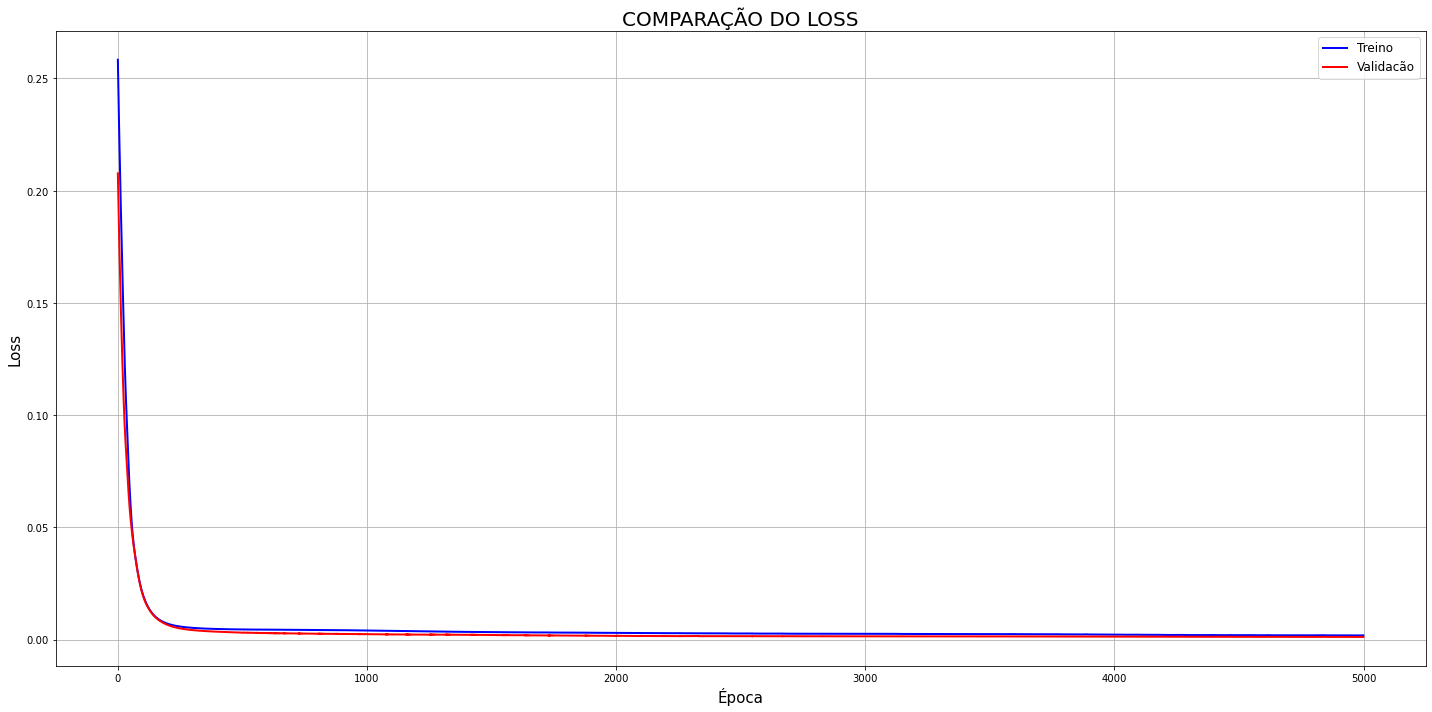

In [18]:
plt.figure(figsize=(20,10))

plt.plot(history.history['loss'], label = "Treino", linewidth =2, color ='blue')        
plt.plot(history.history['val_loss'],'-', label = "Validacão", linewidth =2, color='red')

plt.title('COMPARAÇÃO DO LOSS', fontsize =20)
plt.xlabel('Época', fontsize =15)
plt.ylabel('Loss',fontsize =15)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [19]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 120)            113760    
_________________________________________________________________
lstm_1 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dense (Dense)                (None, 30)                3630      
Total params: 233,070
Trainable params: 233,070
Non-trainable params: 0
_________________________________________________________________


In [20]:
import warnings
warnings.filterwarnings("ignore")
y_train_pred =  modelo.predict(x_train_scaled) 
y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_train = y_scaler.inverse_transform(y_train_scaled)
y_train_pred = pd.DataFrame(y_train_pred)
y_train = pd.DataFrame(y_train)

train_metrics = get_metrics(y_train, y_train_pred)
train_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,7.54809e+10,274738,127242,0.976556,0.955581
1,1.13272e+11,336559,155793,0.964186,0.981777
2,5.14772e+10,226886,105590,0.984031,0.960137
3,3.86369e+10,196563,90162.6,0.987974,0.965831
4,4.16464e+10,204074,90763.5,0.986859,0.949886
5,3.96238e+10,199057,90329.4,0.98744,0.94533
6,4.21638e+10,205338,89262.9,0.986543,0.961276
7,7.15309e+10,267453,124382,0.976917,0.964692
8,1.13691e+11,337181,151078,0.962938,0.980638
9,4.79876e+10,219061,102892,0.984702,0.948747


In [21]:
y_test_pred =  modelo.predict(x_test_scaled) 
y_test_pred = y_scaler.inverse_transform(y_test_pred)
y_test = y_scaler.inverse_transform(y_test_scaled)
y_test_pred = pd.DataFrame(y_test_pred)
y_test = pd.DataFrame(y_test)

test_metrics = get_metrics(y_test, y_test_pred)
test_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,2.86358e+12,1.69221e+06,1.29126e+06,0.89644,0.954733
1,1.52844e+12,1.2363e+06,892075,0.885233,0.967078
2,7.1171e+11,843629,667555,0.914977,0.930041
3,2.31684e+12,1.52212e+06,1.21166e+06,0.936447,0.987654
4,6.02159e+11,775989,634205,0.937012,0.921811
5,4.62557e+11,680115,516970,0.919615,0.987654
6,6.82145e+11,825921,640707,0.916923,1
7,7.34219e+11,856866,645550,0.8848,0.99177
8,8.88354e+11,942526,732928,0.854525,0.995885
9,1.58858e+12,1.26039e+06,942659,0.829321,0.897119


In [22]:
y_val_pred =  modelo.predict(x_val_scaled) 
y_val_pred = y_scaler.inverse_transform(y_val_pred)
y_val = y_scaler.inverse_transform(y_val_scaled)
y_val_pred = pd.DataFrame(y_val_pred)
y_val = pd.DataFrame(y_val)

val_metrics = get_metrics(y_val, y_val_pred)
val_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,6.4291e+10,253557,170554,0.850411,0.925
1,5.56479e+10,235898,158156,0.861333,0.929167
2,2.96233e+10,172114,112917,0.932358,0.991667
3,2.27229e+10,150741,103582,0.950875,0.995833
4,2.41208e+10,155309,106951,0.941034,0.995833
5,2.33358e+10,152761,100592,0.942964,0.995833
6,3.14381e+10,177308,125101,0.927747,0.991667
7,5.28701e+10,229935,152016,0.866255,0.925
8,6.03326e+10,245627,157159,0.843636,0.925
9,2.05003e+10,143179,93145.8,0.950966,0.995833


In [23]:
bahia = regions_test[regions_test['Country/Region'] == 'BA'].copy()
x_bahia, y_bahia = generate_regions_dataset(
    key="Country/Region",
    regions_data=bahia,
    look_back=lookback,
    look_forward=lookforward,
    x_columns=x_columns,
    y_columns=y_columns
)

In [24]:
local="Bahia_"
y_bahia_scaled = y_scaler.transform(y_bahia)

x_bahia_scaled = create_dataset(model_confirmed, model_deaths, normalizador_confirmed,normalizador_deaths,x_scaler,x_bahia)
x_bahia_scaled = np.reshape(x_bahia_scaled, (x_bahia_scaled.shape[0], 1 , x_bahia_scaled.shape[1]))

y_bahia_pred = modelo.predict(x_bahia_scaled)
y_bahia_pred = y_scaler.inverse_transform(y_bahia_pred)

y_bahia = y_scaler.inverse_transform(y_bahia_scaled)

y_bahia_pred = pd.DataFrame(y_bahia_pred)
y_bahia = pd.DataFrame(y_bahia)

bahia_metrics = get_metrics(y_bahia, y_bahia_pred)
bahia_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,3.91167e+11,625434,492095,0.551947,0.983471
1,3.0063e+11,548297,442178,0.459094,0.975207
2,3.96552e+11,629724,519291,0.713402,0.859504
3,4.37924e+11,661758,511107,0.7602,0.983471
4,5.84439e+11,764486,674229,0.786091,0.842975
5,2.1233e+11,460793,372925,0.765366,0.975207
6,2.87038e+11,535759,445017,0.737782,1
7,3.02507e+11,550006,441709,0.529192,0.983471
8,2.81301e+11,530378,448920,0.390642,0.991736
9,4.17182e+11,645896,544233,0.716858,0.859504


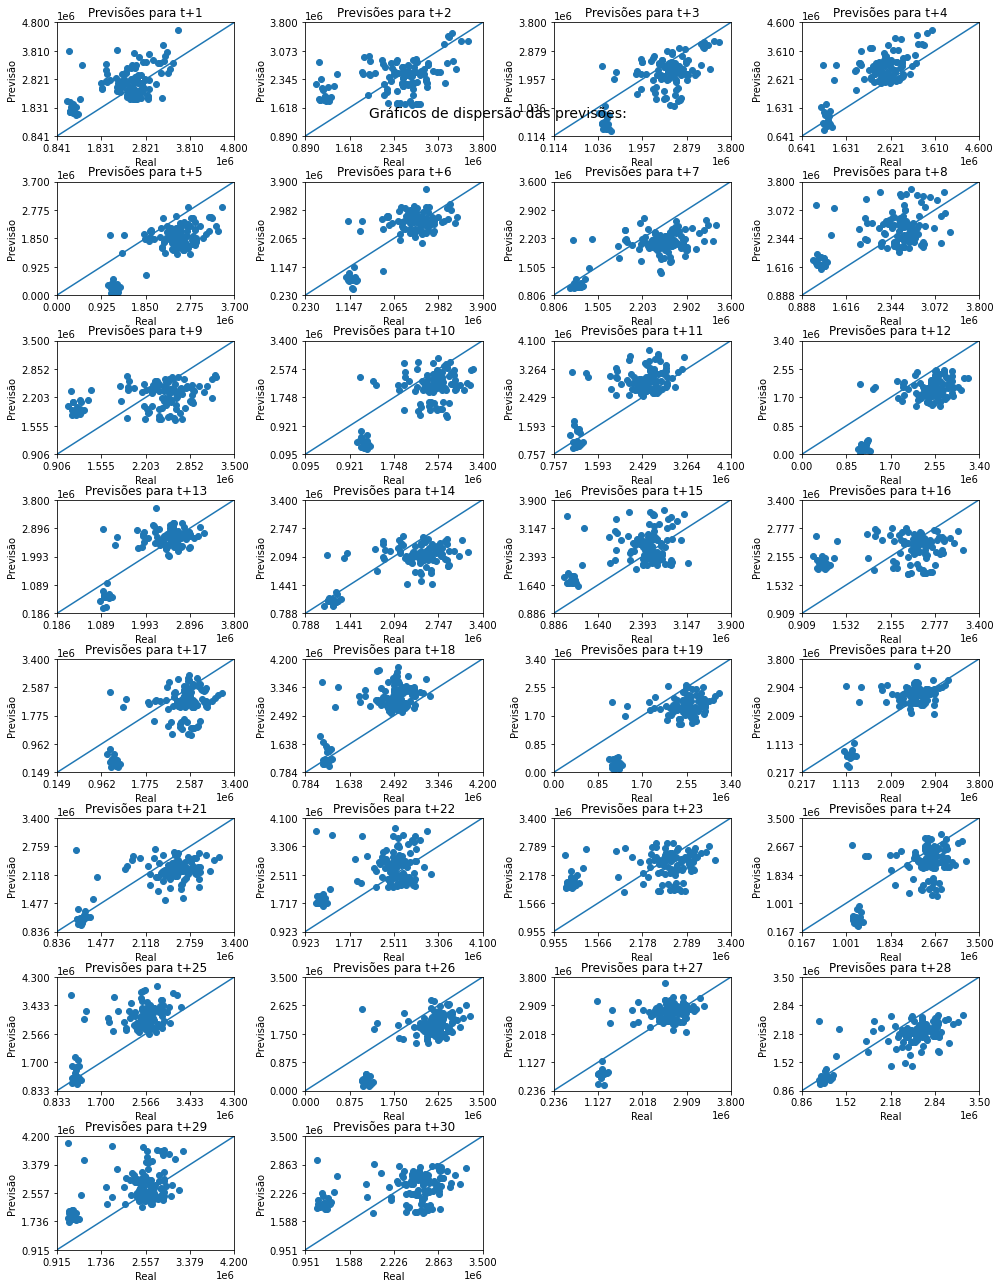

In [25]:
plot_scatter(
    y_bahia,
    y_bahia_pred,
    title='Gráficos de dispersão das previsões: ',
)

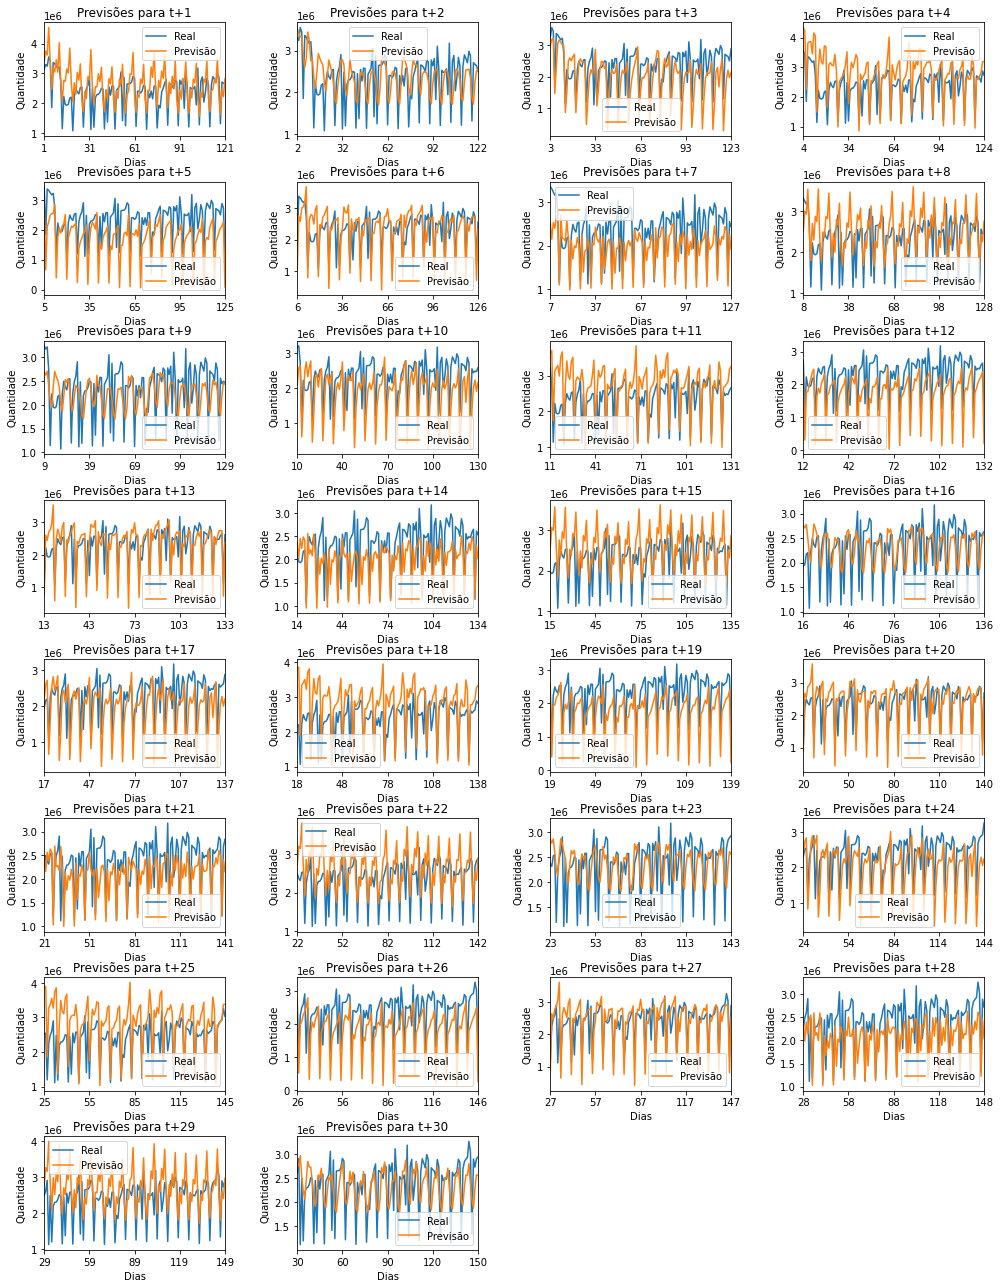

In [26]:
plot_samples(
    y_bahia,
    y_bahia_pred,
    xlabel='Dias',
    ylabel='Quantidade'
)

#### K-FOLD

In [27]:
train_x, train_y = generate_regions_dataset("Country/Region", dados, lookback, lookforward, x_columns, y_columns=y_columns)

In [28]:
from sklearn.model_selection import KFold

In [29]:
import warnings
warnings.filterwarnings('ignore')

kfold = KFold(n_splits=5, shuffle=True)
MSEscores = []
RMSEscores = []
MAEscores = []
FACscores = []
Rscores = []

num_k = 0
for train, test in kfold.split(train_x, train_y):
    #Arquitetura da RNA
    normalizador_kfold = MinMaxScaler(feature_range=(0, 1))
    normalizador_kfold.fit(train_x.iloc[train])
    
    normalizador_kfold_y = MinMaxScaler(feature_range=(0, 1))
    y_kfold_train = normalizador_kfold_y.fit_transform(train_y.iloc[train])
    
    y_kfold_test = normalizador_kfold_y.transform(train_y.iloc[test])
    
    new_kfold_train = create_dataset(model_confirmed, model_deaths, normalizador_confirmed, normalizador_deaths, normalizador_kfold, train_x.iloc[train])
    new_kfold_train = np.reshape(new_kfold_train, (new_kfold_train.shape[0], 1 , new_kfold_train.shape[1]))
    
    new_kfold_test = create_dataset(model_confirmed, model_deaths, normalizador_confirmed, normalizador_deaths, normalizador_kfold, train_x.iloc[test])
    new_kfold_test = np.reshape(new_kfold_test, (new_kfold_test.shape[0], 1 , new_kfold_test.shape[1]))
            
    kfold_train = new_kfold_train
    kfold_test = new_kfold_test
    
    #Arquitetura da RNA
    activation = 'relu'
    opt = optimizers.Adamax()

    tf.random.set_seed(0)

    modelo = Sequential()
    modelo.add(LSTM(units = 120, return_sequences = True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape = (new_kfold_train.shape[1],new_kfold_train.shape[2])))
    modelo.add(LSTM(units = 120, activation = 'relu'))
    modelo.add(Dense(units = lookforward, activation = 'linear'))

    modelo.compile(optimizer=opt, loss='mse')

    modelo.fit(kfold_train, y_kfold_train, shuffle=False ,batch_size = 1500, epochs = 3043, verbose=0)
    
    observado = y_kfold_test
    predicao =  modelo.predict(kfold_test)
    predicao = normalizador_kfold_y.inverse_transform(predicao)
    observado = normalizador_kfold_y.inverse_transform(observado)
    
    metricas_qualidade = get_metrics(pd.DataFrame(observado), pd.DataFrame(predicao), filename="K_FOLD_SEM_INFERENCIA_CONFIRMED_LSTM")
    MSE = metricas_qualidade["MSE"].mean()
    RMSE = metricas_qualidade["RMSE"].mean()
    MAE = metricas_qualidade["MAE"].mean()
    R = metricas_qualidade["Pearson r"].mean()
    FAC2 = metricas_qualidade["Fac2"].mean()
    
    print("K: " + str(num_k))
    print("MSE: ", MSE)
    print("RMSE: ", RMSE)
    print("MAE: ", MAE)
    print("R: ", R)
    print("FAC2: ", FAC2)
    print("-----------------------------------")
    MSEscores.append(MSE)
    RMSEscores.append(RMSE)
    MAEscores.append(MAE)
    Rscores.append(R)
    FACscores.append(FAC2)
    num_k = num_k + 1
    
print("RESULTS K-FOLD: ")
print("MSE: " + str(np.mean(MSEscores)) + " +/- " +  str(np.std(MSEscores)))
print("RMSE: " + str(np.mean(RMSEscores)) + " +/- " +  str(np.std(RMSEscores)))
print("MAE: " + str(np.mean(MAEscores)) + " +/- " +  str(np.std(MAEscores)))
print("R: " + str(np.mean(Rscores)) + " +/- " +  str(np.std(Rscores)))
print("FAC2: " + str(np.mean(FACscores)) + " +/- " +  str(np.std(FACscores)))

K: 0
MSE:  92347208014.00983
RMSE:  297014.06519052765
MAE:  165843.26496936017
R:  0.9834424002169626
FAC2:  0.950915750915751
-----------------------------------
K: 1
MSE:  120318248731.37337
RMSE:  339818.7162734462
MAE:  188422.94483816114
R:  0.9797202075012584
FAC2:  0.9490196078431373
-----------------------------------
K: 2
MSE:  124617087671.16644
RMSE:  338319.87993371557
MAE:  187362.63284240421
R:  0.9797265084634644
FAC2:  0.9634803921568628
-----------------------------------
K: 3
MSE:  116934835573.68205
RMSE:  332959.01299343957
MAE:  175655.18759352734
R:  0.9813685075577347
FAC2:  0.9582107843137256
-----------------------------------
K: 4
MSE:  112294586968.21584
RMSE:  327397.6265380962
MAE:  182046.77690738163
R:  0.9801289576881371
FAC2:  0.9550245098039217
-----------------------------------
RESULTS K-FOLD: 
MSE: 113302393391.6895 +/- 11230090266.698952
RMSE: 327101.86018584506 +/- 15666.726015624676
MAE: 179866.1614301669 +/- 8349.187213000487
R: 0.9808773162855

#### TREINAMENTO COM DADOS COMPLETOS

In [30]:
train_x, train_y = generate_regions_dataset("Country/Region", dados, lookback, lookforward, x_columns, y_columns=y_columns)

In [31]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_scaler.fit(train_x)

y_train_scaled = y_scaler.fit_transform(train_y)

#### SALVANDO O NORMALIZADOR
dump(x_scaler, open('Xscaler_Qtde.pkl', 'wb'))
dump(y_scaler, open('Yscaler_Qtde.pkl', 'wb'))

In [32]:
x_train_scaled = create_dataset(model_confirmed, model_deaths, normalizador_confirmed, normalizador_deaths,x_scaler,train_x)

In [33]:
x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0], 1 , x_train_scaled.shape[1]))

In [34]:
#Arquitetura da RNA
activation = 'relu'
opt = optimizers.Adamax()

tf.random.set_seed(0)

modelo = Sequential()
modelo.add(LSTM(units = 120, return_sequences = True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape = (x_train_scaled.shape[1],x_train_scaled.shape[2])))
modelo.add(LSTM(units = 120, activation = 'relu'))
modelo.add(Dense(units = lookforward, activation = 'linear'))

modelo.compile(optimizer=opt, loss='mse')

history = modelo.fit(x_train_scaled, y_train_scaled, shuffle=False ,batch_size = 1500, epochs = 3043, verbose=1)

Train on 1361 samples
Epoch 1/3043
1361/1361 [==============================] - 3s 2ms/sample - loss: 0.2758
Epoch 2/3043
1361/1361 [==============================] - 0s 24us/sample - loss: 0.2691
Epoch 3/3043
1361/1361 [==============================] - 0s 23us/sample - loss: 0.2627
Epoch 4/3043
1361/1361 [==============================] - 0s 22us/sample - loss: 0.2566
Epoch 5/3043
1361/1361 [==============================] - 0s 22us/sample - loss: 0.2506
Epoch 6/3043
1361/1361 [==============================] - 0s 22us/sample - loss: 0.2448
Epoch 7/3043
1361/1361 [==============================] - 0s 24us/sample - loss: 0.2391
Epoch 8/3043
1361/1361 [==============================] - 0s 31us/sample - loss: 0.2335
Epoch 9/3043
1361/1361 [==============================] - 0s 25us/sample - loss: 0.2281
Epoch 10/3043
1361/1361 [==============================] - 0s 23us/sample - loss: 0.2227
Epoch 11/3043
1361/1361 [==============================] - 0s 22us/sample - loss: 0.2174
Epoch 12/

In [35]:
modelo.save('LSTM_NotasFiscais_Qtde.h5')

In [36]:
import warnings
warnings.filterwarnings("ignore")
y_train_pred =  modelo.predict(x_train_scaled) 
y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_train = y_scaler.inverse_transform(y_train_scaled)
y_train_pred = pd.DataFrame(y_train_pred)
y_train = pd.DataFrame(y_train)

train_metrics = get_metrics(y_train, y_train_pred)
train_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,1.91184e+11,437246,242072,0.967668,0.95665
1,1.30326e+11,361007,200684,0.977863,0.947832
2,8.28678e+10,287868,159954,0.985963,0.950771
3,7.00596e+10,264688,140296,0.988057,0.963997
4,7.09956e+10,266450,150589,0.987718,0.916973
5,6.43636e+10,253700,141384,0.988742,0.964732
6,9.14192e+10,302356,167721,0.983857,0.961058
7,1.80215e+11,424517,228594,0.967894,0.966936
8,1.30541e+11,361304,200451,0.976714,0.964732
9,6.86005e+10,261917,143531,0.987836,0.95518


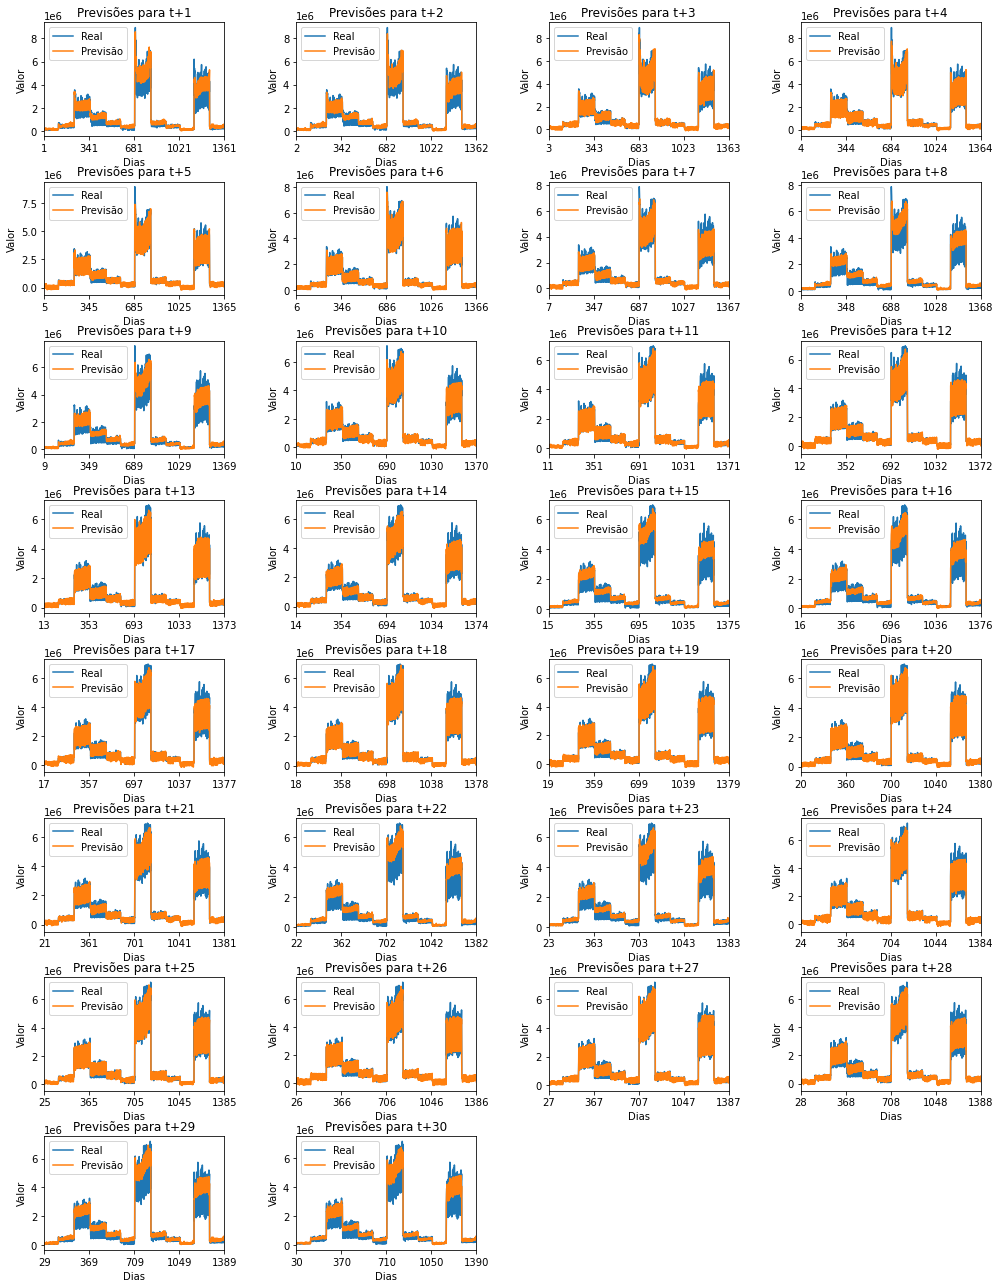

In [37]:
plot_samples(
    y_train,
    y_train_pred,
    xlabel='Dias',
    ylabel='Valor'
)